In [ ]:
# import google drive and check file 
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
!pip install --upgrade tensorflow
!pip install keras-tuner --upgrade
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install keras-cv
!pip install tensorflow_addons


In [ ]:
# !mkdir data
# !unzip /mydrive/VGG/pepsi_mirinda_1.zip -d data/train
# !mkdir data/test
# !unzip /mydrive/VGG/test_2.zip -d data/test
# !mkdir data/valid
# !unzip /mydrive/VGG/valid_3.zip -d data/valid
!mkdir data2
!unzip /mydrive/VGG/train_tiger_crop_mix.zip -d data2/train
!mkdir data2/test
!unzip /mydrive/VGG/test_tiger_crop.zip -d data2/test

In [ ]:
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications, losses, optimizers, Model, regularizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, VGG16, MobileNetV3Large, ResNet50V2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, StratifiedKFold
import keras_tuner
import cv2


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data2/train',
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)
valid_ds = tf.keras.utils.image_dataset_from_directory(
  'data2/test',
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
# test_ds = tf.keras.utils.image_dataset_from_directory(
#   'data/test',
#   label_mode='categorical',
#   seed=123,
#   image_size=(img_height, img_width),
#   shuffle=False,
#   batch_size=batch_size)

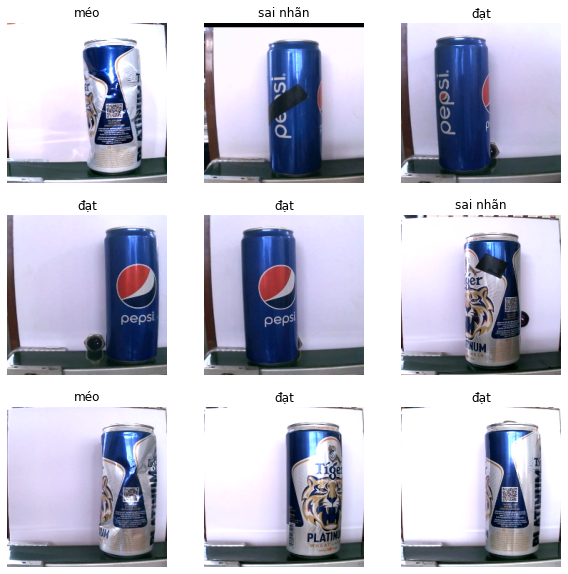

In [ ]:
plt.figure(figsize=(10, 10))
class_names = ['background', 'đạt', 'méo', 'sai nhãn']
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(labels[i], axis=0)])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
cut_mix = keras_cv.layers.CutMix(alpha=1.0)
mix_up = keras_cv.layers.MixUp(alpha=0.2)
cut_out = keras_cv.layers.RandomCutout(
    (0.3, 0.3), 
    (0.3, 0.3),
    fill_mode="constant"
)

random_gridmask = keras_cv.layers.preprocessing.GridMask(ratio_factor=(0, 0.4),
                                                         fill_mode="constant"
                                                         )
rand_flip = tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical",
    seed=123
)
rand_brightness =  tf.keras.layers.RandomBrightness(
    0.2, 
    value_range=(0, 255), 
    seed=123
)
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
)
rand_aug_bf = keras_cv.layers.RandomAugmentationPipeline(
    layers=[rand_flip, rand_brightness],
    augmentations_per_image=2,
)
rand_aug_cutout = keras_cv.layers.RandomAugmentationPipeline(
    layers=[cut_out],
    augmentations_per_image=1,
    rate=0.5
)
def adjust_gamma(image, gamma=1.8):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [ ]:
#không chạy khi dùng kfold valid
train_ds = train_ds.map(lambda x, y: {'images': x, 'labels': y})
valid_ds = valid_ds.map(lambda x, y: {'images': x, 'labels': y})

In [ ]:
def apply_pre_pos(inputs):
  # inputs['images'] = tfa.image.gaussian_filter2d(inputs['images'], filter_shape=(5, 5))     #dòng này khi chạy bt/hyperband không dùng k-fold
  inputs = tfa.image.gaussian_filter2d(inputs, filter_shape(5, 5))                            #dòng này khi chạy kfold/hyperband dùng k-fold
  return inputs                                                                               #tương tự cho các hàm khác

# train_ds = train_ds.map(lambda x: apply_pre_pos(x))                                         #cần apply vào tập nào thì dùng cho tập đó
# valid_ds = valid_ds.map(lambda x: apply_pre_pos(x))
# test_ds = test_ds.map(lambda x: apply_pre_pos(x))


In [ ]:
#Random độ sáng, lật ngang dọc
def apply_bf_augment(inputs):
  # inputs["images"] = rand_flip(inputs["images"], training=True)
  # inputs["images"] = rand_brightness(inputs["images"], training=True)
  inputs = rand_flip(inputs, training=True)
  inputs = rand_brightness(inputs, training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_bf_augment(x))
valid_ds = valid_ds.map(lambda x: apply_bf_augment(x))

In [ ]:
#Random gridmask
def apply_grid_augment(inputs):
    # inputs["images"] = random_gridmask(inputs["images"], training=True)
    inputs = random_gridmask(inputs, training=True)
    return inputs
# train_ds = train_ds.map(lambda x: apply_grid_augment(x))
# valid_ds = valid_ds.map(lambda x: apply_grid_augment(x))

In [ ]:
#Cutmix-dùng cutmix hoặc mixup phải truyền cả ảnh và label vào mới chạy được, nếu dùng cho k-fold thì không được shuffle khi tạo tập data
def apply_cutmix_augment(inputs):
  inputs = cut_mix(inputs, training=True)
  return inputs
# train_ds = train_ds.map(lambda x: apply_cutmix_augment(x))

In [ ]:
#Mixup
def apply_mixup_augment(inputs):
  inputs = mix_up(inputs, training=True)
  return inputs
# train_ds = train_ds.map(lambda x: apply_mixup_augment(x))

In [ ]:
#Cutout
def apply_cutout_augment(inputs):
  inputs = cut_out(inputs, training=True)
  return inputs
train_ds = train_ds.map(lambda x: apply_cutout_augment(x))
valid_ds = valid_ds.map(lambda x: apply_cutout_augment(x))

In [ ]:
#thay đổi contrast
def adjust_contrast(img, clipLimit=6, tileGridSize=(12, 12)):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

#tính lv contrast
def lv_contrast(img):
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)

    # separate channels
    L,A,B=cv2.split(lab)

    # compute minimum and maximum in 5x5 region using erode and dilate
    kernel = np.ones((7,7),np.uint8)
    min = cv2.erode(L,kernel,iterations = 1)
    max = cv2.dilate(L,kernel,iterations = 1)

    # convert min and max to floats
    min = min.astype(np.float32)
    max = max.astype(np.float32)

    # compute local contrast
    contrast = (max-min)/(max+min)
    average_contrast = 100*np.nanmean(contrast)
    # get average across whole image
    return average_contrast

#chỉnh gamma
def adjust_gamma(image, gamma=1.8):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


In [ ]:
#dùng khi k chạy liên quan đến kfold
train_ds = train_ds.map(lambda inputs: (inputs["images"], inputs["labels"]))
valid_ds = valid_ds.map(lambda inputs: (inputs["images"], inputs["labels"]))
# test_ds = test_ds.map(lambda inputs: (inputs["images"], inputs["labels"]))

In [ ]:
#dùng khi chạy kfold-tác dụng nối các data lại với nhau thành list ảnh và label do k-fold không nhận dữ liệu dạng tf.data
train_ds_images = np.concatenate(list(train_ds.map(lambda x, y: x)))
train_ds_labels = np.concatenate(list(train_ds.map(lambda x, y: y)))
valid_ds_images = np.concatenate(list(valid_ds.map(lambda x, y: x)))
valid_ds_labels = np.concatenate(list(valid_ds.map(lambda x, y: y)))
# valid_ds_images = np.concatenate(list(valid_ds.map(lambda inputs: inputs['images'])))
# valid_ds_labels = np.concatenate(list(valid_ds.map(lambda inputs: inputs['labels'])))

In [ ]:
inputs = np.concatenate((train_ds_images, valid_ds_images), axis=0)
targets = np.concatenate((train_ds_labels, valid_ds_labels), axis=0)
inputs.shape
targets.shape

(1102, 4)

In [ ]:
# train_ds_images = np.array([apply_pre_pos(i) for i in train_ds_images])
train_ds_images = np.array([apply_bf_augment(i) for i in train_ds_images])
train_ds_images = np.array([apply_cutout_augment(i) for i in train_ds_images])
valid_ds_images = np.array([apply_pre_pos(i) for i in valid_ds_images])


In [ ]:
#Show ảnh khi dùng cho kfold
plt.figure(figsize=(10, 10))
import random
class_names = ['background', 'dat', 'meo', 'sai_nhan']
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
a = random.randint(10, 200)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(inputs[i+a].astype('uint8'))
  plt.title(class_names[np.argmax(targets[i+a], axis=0)])
  plt.axis("off")

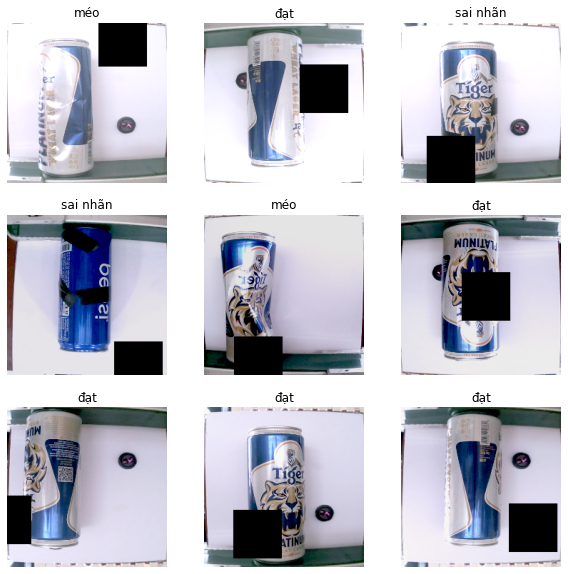

In [ ]:
#Show ảnh khi k dùng kfold
plt.figure(figsize=(10, 10))
class_names = ['background', 'đạt', 'méo', 'sai nhãn']
i=0
for images in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    img = adjust_gamma(images[0][0].numpy().astype(np.uint8))
    # img = (img.astype(np.float)) 
    plt.imshow(img)
    plt.title(class_names[np.argmax(images[1][0], axis=0)])
    plt.axis("off")
    i +=1

In [ ]:
#Khơi tạo model cho kfold
def get_model():
  mobile_net = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in mobile_net.layers:
    if 'conv_10' in layer.name:
      if not isinstance(layer, BatchNormalization):
        layer.trainable=True
      else:
        layer.trainable=False
    else:
      layer.trainable=False
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
  x = mobile_net(x)
  x = GlobalAveragePooling2D()(x) # Flatten dimensions to for use in FC layers
  x = Dense(320)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dense(4, activation='softmax')(x) # Softmax for multiclass
  transfer_model = Model(inputs=inputs, outputs=x)

  transfer_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                        metrics=["accuracy"])
  return transfer_model

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=4, verbose=1, mode='max', min_lr=5e-5)
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#chạy kfold
kfold = StratifiedKFold(n_splits=5)
fold_idx = 1
acc = []
loss = []
for i, (train, test) in enumerate(kfold.split(inputs, targets.argmax(1))):

  model = get_model()

  print("Bắt đầu train Fold ", fold_idx)

  backup_test = inputs[test]
  backup_train = inputs[train]
  inputs[test] = [apply_pre_pos(i) for i in inputs[test]]
  # inputs[test] = [apply_bf_augment(i) for i in inputs[test]]
  # inputs[test] = [apply_cutout_augment(i) for i in inputs[test]]
  inputs[train] = [apply_pre_pos(i) for i in inputs[train]]
  inputs[train] = [apply_bf_augment(i) for i in inputs[train]]
  inputs[train] = [apply_grid_augment(i) for i in inputs[train]]
  
  # Train model
  checkpoint = ModelCheckpoint(f'mobilenet/mobinet_hp_{fold_idx}.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
  history = model.fit(inputs[train], targets[train],
              epochs=20,
            validation_data = (np.array(inputs[test]), np.array(targets[test])),
              callbacks=[lr_reduce, checkpoint, stopping])

  # Test và in kết quả
  model = tf.keras.models.load_model(f'mobilenet/mobinet_hp_{fold_idx}.h15')
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print("Đã train xong Fold ", fold_idx)

  # Thêm thông tin accuracy và loss vào list
  acc.append(scores[1] * 100)
  loss.append(scores[0])
  mobilenet.append(history)
  # Sang Fold tiếp theo
  inputs[test] = backup_test
  inputs[train] = backup_train
  fold_idx = fold_idx + 1

In [ ]:
print(sum(acc) / len(acc))
print(acc)
print(sum(loss) / len(loss))

In [ ]:
#Tạo model cho hyperband thường
# class MyHyperModel(keras_tuner.HyperModel):
    # def build(self, hp):
def build_model(hp):
    VGG16_with_DataAug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in VGG16_with_DataAug.layers:
      if 'block5' in layer.name:
        layer.trainable=True
      else:
        layer.trainable=False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = VGG16_with_DataAug(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dense(160)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(448)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(4, activation='softmax')(x)
    VGG16_with_DataAug = Model(inputs=inputs, outputs=x)
    optimizers = hp.Choice('optimizers', ['adam', 'sgd', 'rmsprop', 'Yogi'])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, step=1e-4)
    # with hp.conditional_scope("optimizers", ["adam"]):
    if optimizers == 'adam':  
        optimizers = tf.keras.optimizers.Adam(learning_rate)
    # with hp.conditional_scope("optimizers", ["sgd"]):
    elif optimizers == 'sgd':
        momentum = hp.Float("momentum", min_value=0.0, max_value=0.9, step=0.1)
        optimizers = tf.keras.optimizers.SGD(learning_rate, momentum)
    # with hp.conditional_scope("optimizers", ["rmsprop"]):
    elif optimizers == 'rmsprop':
        optimizers = tf.keras.optimizers.RMSprop(learning_rate)
    else:
        optimizers = tfa.optimizers.Yogi(learning_rate)
    VGG16_with_DataAug.compile(
        optimizer=optimizers,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return VGG16_with_DataAug
    # def fit(self, hp, mobile_net, x, y, validation_data=None, batch_size=32,
    #          epochs=2, **kwargs):
    #     return model.fit(
    #         np.array(x),
    #         np.array(y),
    #         batch_size=batch_size,
    #          epochs=epochs,
    #          **kwargs
    #     )

In [ ]:
#Khởi tạo class MyHypermodel và MyTuner để chạy được kfold khi dùng hyperband/tương tự cho randomsearch và bayesian


# class MyHyperModel(keras_tuner.HyperModel):
#     def build(self, hp):
#       VGG16_with_DataAug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#       for layer in VGG16_with_DataAug.layers:
#         if 'block5' in layer.name:
#           layer.trainable=True
#         else:
#           layer.trainable=False
#       inputs = tf.keras.Input(shape=(224, 224, 3))
#       x = tf.keras.applications.vgg16.preprocess_input(inputs)
#       x = VGG16_with_DataAug(x)
#       x = GlobalAveragePooling2D()(x)
#       x = Dense(64)(x)
#       x = Activation('relu')(x)
#       x = Dense(160)(x)
#       x = Activation('relu')(x)
#       x = Dropout(0.1)(x)
#       x = Dense(448)(x)
#       x = BatchNormalization()(x)
#       x = Activation('relu')(x)
#       x = Dense(4, activation='softmax')(x)
#       VGG16_with_DataAug = Model(inputs=inputs, outputs=x)
#       optimizers = hp.Choice('optimizers', ['adam', 'sgd', 'rmsprop', 'Yogi'])
#       learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, step=1e-4)
#       # with hp.conditional_scope("optimizers", ["adam"]):
#       if optimizers == 'adam':  
#           optimizers = tf.keras.optimizers.Adam(learning_rate)
#       # with hp.conditional_scope("optimizers", ["sgd"]):
#       elif optimizers == 'sgd':
#           momentum = hp.Float("momentum", min_value=0.0, max_value=0.9, step=0.1)
#           optimizers = tf.keras.optimizers.SGD(learning_rate, momentum)
#       # with hp.conditional_scope("optimizers", ["rmsprop"]):
#       elif optimizers == 'rmsprop':
#           optimizers = tf.keras.optimizers.RMSprop(learning_rate)
#       else:
#           optimizers = tfa.optimizers.Yogi(learning_rate)
#       VGG16_with_DataAug.compile(
#           optimizer=optimizers,
#           loss="categorical_crossentropy",
#           metrics=["accuracy"],
#       )
#       return VGG16_with_DataAug
#     def fit(self, hp, mobile_net, x, y, validation_data=None, batch_size=32,
#              epochs=2, **kwargs):
#         return model.fit(
#             np.array(x),
#             np.array(y),
#             batch_size=batch_size,
#              epochs=epochs,
#              **kwargs
#         )
# class MyTuner(keras_tuner.engine.tuner.Tuner):
#   def run_trial(self, trial, x, y, batch_size=32, epochs=4):
#     kfold = StratifiedKFold(5)
#     val_acc = []
#     hp = keras_tuner.HyperParameters()
#     hypermodel = MyHyperModel()
#     for i, (train_indices, test_indices) in enumerate(kfold.split(x, y.argmax(1))):
#       x_train, x_test = x[train_indices], x[test_indices]
#       y_train, y_test = y[train_indices], y[test_indices]
#       backup = x_test
#       x_test = [apply_pre_pos(i) for i in x_test]
#       x_test = [apply_cutout_augment(i) for i in x_test]
#       x_test = [apply_bf_augment(i) for i in x_test]
#       model = self.hypermodel.build(trial.hyperparameters)
#       model.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=epochs)
#       # model.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=epochs)
#       scores = model.evaluate(np.array(x_test), np.array(y_test))
#       val_acc.append(scores[1] * 100)
#       x_test = backup
#     self.oracle.update_trial(trial.trial_id, {'val_acc': np.mean(val_acc)})
#     save_path = os.path.join("/tmp", trial.trial_id)
#     model.save(save_path)

In [ ]:
#Khởi tạo tuner
tuner = keras_tuner.Tuner(
    hypermodel=build_model,
    oracle=keras_tuner.oracles.RandomSearch(
    objective='val_accuracy',
    max_trials=300,
    seed=123),
    directory='vgg'
    )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Khởi tạo các callbacks có thể dùng
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=4, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('mobile_net_1Ge1D.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search_space_summary(extended=True)
# tuner.search(np.array(train_ds_images), np.array(train_ds_labels), validation_data=(valid_ds_images, valid_ds_labels), epochs = 10, callbacks=[stopping])     #dùng khi chạy kfold
tuner.search(train_ds, validation_data=valid_ds, epochs = 10, callbacks=[stopping])                                                                             #dùng khi chạy bt

Trial 43 Complete [00h 00m 53s]
val_accuracy: 0.9147540926933289

Best val_accuracy So Far: 0.9409835934638977
Total elapsed time: 00h 47m 21s

Search: Running Trial #44

Value             |Best Value So Far |Hyperparameter
Yogi              |adam              |optimizers
0.0004            |0.0006            |learning_rate
0.6               |0                 |momentum

Epoch 1/10
39/39 [==============================] - 10s 216ms/step - loss: 0.7529 - accuracy: 0.6710 - val_loss: 1.4052 - val_accuracy: 0.6459
Epoch 2/10
39/39 [==============================] - 8s 211ms/step - loss: 0.4066 - accuracy: 0.8241 - val_loss: 0.7670 - val_accuracy: 0.7672
Epoch 3/10
39/39 [==============================] - 8s 203ms/step - loss: 0.2538 - accuracy: 0.9031 - val_loss: 0.7854 - val_accuracy: 0.7508
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9202

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()


Results summary
Results in vgg/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
optimizers: adam
learning_rate: 0.0006000000000000001
momentum: 0.0
Score: 0.9409835934638977
Trial summary
Hyperparameters:
optimizers: Yogi
learning_rate: 0.0005
momentum: 0.7000000000000001
Score: 0.9409835934638977
Trial summary
Hyperparameters:
optimizers: Yogi
learning_rate: 0.0002
momentum: 0.5
Score: 0.9377049207687378
Trial summary
Hyperparameters:
optimizers: Yogi
learning_rate: 0.001
momentum: 0.9
Score: 0.9311475157737732
Trial summary
Hyperparameters:
optimizers: Yogi
learning_rate: 0.0002
momentum: 0.8
Score: 0.9311475157737732
Trial summary
Hyperparameters:
optimizers: adam
learning_rate: 0.0008
momentum: 0.5
Score: 0.9278688430786133
Trial summary
Hyperparameters:
optimizers: Yogi
learning_rate: 0.0009000000000000001
momentum: 0.2
Score: 0.9245901703834534
Trial summary
Hyperparameters:
optimizers: rmsprop
learning_rate: 0.0004
momentum: 0.6000000000000001
Score: 0.9213

In [ ]:
def get_resnet():
  resnet50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  for layer in resnet50v2.layers:
      if 'conv5' in layer.name:
        if not isinstance(layer, BatchNormalization):
          layer.trainable=True
        else:
          layer.trainable=False
      else:
        layer.trainable=False
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
  x = resnet50v2(x)
  x = GlobalAveragePooling2D()(x) # Flatten dimensions to for use in FC layers
  # # x = Dense(256)(x)
  # # x = BatchNormalization()(x)
  # # x = Activation('relu')(x)
  # # x = Dropout(0.5)(x)
  # x = Dense(512)(x)
  # x = Dropout(0.5)(x)
  # x = Activation('relu')(x)
  x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
  x = Activation('relu')(x)
  x = Dense(4, activation='softmax')(x)
  resnet50v2 = Model(inputs=inputs, outputs=x)

  resnet50v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                        metrics=["accuracy"])
  return resnet50v2

for train, test in kfold.split(inputs, targets):

  model = get_resnet()

  print("Bắt đầu train Fold ", fold_idx)

  # Train model
  model.fit(inputs[train], targets[train],
              epochs=20,
            validation_data = (inputs[test], targets[test]),
              callbacks=[lr_reduce, checkpoint, stopping])

  # Test và in kết quả
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print("Đã train xong Fold ", fold_idx)

  # Thêm thông tin accuracy và loss vào list
  acc.append(scores[1] * 100)
  loss.append(scores[0])

  # Sang Fold tiếp theo
  fold_idx = fold_idx + 1

In [ ]:
from tensorflow.python.ops.gen_math_ops import xdivy
# class MyHyperModel(keras_tuner.HyperModel):
    # def build(self, hp):
def build_model(hp):
    resnet50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    if hp.Boolean('Fine-tunning'):
      for layer in resnet50v2.layers:
        if 'conv5' in layer.name:
          if not isinstance(layer, BatchNormalization):
            layer.trainable=True
          else:
            layer.trainable=False
        else:
          layer.trainable=False
    else:
      for layer in resnet50v2.layers:
          layer.trainable=False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    x = resnet50v2(x)
    x = GlobalAveragePooling2D()(x)
    r = hp.Int("num_layers", 1, 3)
    # Tune the number of layers.
    for i in range(r):
        x = Dense(units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32))(x)
        if hp.Boolean(f"Batchnorm_{i}"):
          x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if hp.Boolean(f"dropout_{i}"):
          rate = hp.Float(f"dropout_rate_{i}", min_value=0.0, max_value=0.5, step=0.1)
          x = Dropout(rate=rate)(x)
    x = Dense(4, activation="softmax")(x)
    resnet50v2 = Model(inputs=inputs, outputs=x)
    optimizers = hp.Choice('optimizers', ['adam', 'sgd', 'rmsprop', 'Yogi'])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, step=1e-4)
    # with hp.conditional_scope("optimizers", ["adam"]):
    if optimizers == 'adam':  
        optimizers = tf.keras.optimizers.Adam(learning_rate)
    # with hp.conditional_scope("optimizers", ["sgd"]):
    elif optimizers == 'sgd':
        momentum = hp.Float("momentum", min_value=0.0, max_value=0.9, step=0.1)
        optimizers = tf.keras.optimizers.SGD(learning_rate)
    # with hp.conditional_scope("optimizers", ["rmsprop"]):
    elif optimizers == 'rmsprop':
        optimizers = tf.keras.optimizers.RMSprop(learning_rate)
    else:
        optimizers = tfa.optimizers.Yogi(learning_rate)
    resnet50v2.compile(
        optimizer=optimizers,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return resnet50v2

In [ ]:
tuner = keras_tuner.Tuner(
    hypermodel=build_model,
    oracle=keras_tuner.oracles.Hyperband(
    objective='val_accuracy',
    max_epochs=40,
    hyperband_iterations=2),
    directory='1'
    )

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
tuner.search_space_summary(extended=True)
tuner.search(np.array(train_ds_images), np.array(train_ds_labels), validation_data=(valid_ds_images, valid_ds_labels), callbacks=[stopping], epochs=10)

Trial 166 Complete [00h 01m 12s]
val_accuracy: 0.6952381134033203

Best val_accuracy So Far: 0.8380952477455139
Total elapsed time: 03h 15m 09s

Search: Running Trial #167

Value             |Best Value So Far |Hyperparameter
True              |True              |Fine-tunning
2                 |2                 |num_layers
448               |32                |units_0
True              |False             |Batchnorm_0
True              |False             |dropout_0
sgd               |adam              |optimizers
0.0003            |0.0004            |learning_rate
352               |96                |units_1
False             |True              |Batchnorm_1
True              |True              |dropout_1
0.4               |0.1               |dropout_rate_0
0.5               |0.3               |dropout_rate_1
192               |416               |units_2
True              |True              |Batchnorm_2
True              |True              |dropout_2
0.2               |0.7             

INFO:tensorflow:Assets written to: ram://f3bdb2c4-9f67-480e-943e-6ad2aea4b8d8/assets


INFO:tensorflow:Assets written to: ram://f3bdb2c4-9f67-480e-943e-6ad2aea4b8d8/assets


ValueError: ignored

In [ ]:
tuner.results_summary()


In [ ]:
# model = tf.keras.models.load_model('mobile_net_1Ge1D.h15')
model = tf.keras.models.load_model('Resnet_1Ge1D.h15')

pred = model.predict(test_ds)
pred = np.argmax(pred,axis=1)

# Map the label
labels = ('background', 'dat', 'meo', 'sai_nhan')
pred = [labels[k] for k in pred]

7/7 [==============================] - 3s 262ms/step


In [ ]:
y_test=[]
for i in test_ds:
  for j in i[1]:
    y_test.append(np.argmax(j))

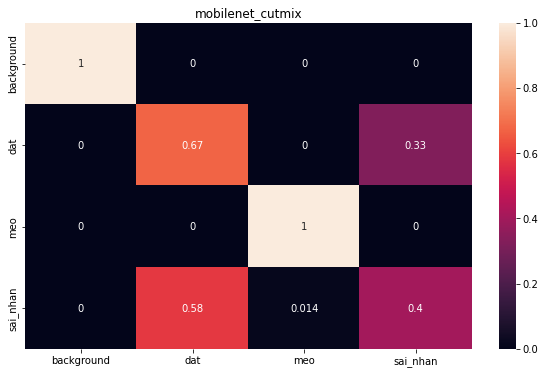

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
y_test = [labels[i] for i in y_test]
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('mobilenet_cutmix')
plt.show()

In [ ]:
!zip -r /mydrive/VGG/mobile_net_1Ge3D_gridmask.zip /content/mobile_net_1Ge1D.h15

  adding: content/mobile_net_1Ge1D.h15/ (stored 0%)
  adding: content/mobile_net_1Ge1D.h15/keras_metadata.pb (deflated 96%)
  adding: content/mobile_net_1Ge1D.h15/saved_model.pb (deflated 91%)
  adding: content/mobile_net_1Ge1D.h15/assets/ (stored 0%)
  adding: content/mobile_net_1Ge1D.h15/variables/ (stored 0%)
  adding: content/mobile_net_1Ge1D.h15/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/mobile_net_1Ge1D.h15/variables/variables.index (deflated 76%)
